# Linear Regression

## Agenda

1. Introducing the bikeshare dataset
    - Reading in the data
    - Visualizing the data
2. Linear regression basics
    - Form of linear regression
    - Building a linear regression model
    - Using the model for prediction
    - Does the scale of the features matter?
3. Working with multiple features
    - Visualizing the data (part 2)
    - Adding more features to the model
4. Choosing between models
    - Feature selection
    - Evaluation metrics for regression problems
    - Comparing models with train/test split and RMSE
    - Comparing testing RMSE with null RMSE
5. Creating features
    - Handling categorical features
    - Feature engineering
6. Comparing linear regression with other models

## Reading in the data

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

Index(['WBAN', 'Date', 'Time', 'StationType', 'SkyCondition', 'Visibility',
       'WeatherType', 'temp', 'DryBulbCelsius', 'WetBulbFarenheit',
       'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius', 'humidity',
       'WindSpeed', 'WindDirection', 'ValueForWindCharacter',
       'StationPressure', 'PressureTendency', 'PressureChange',
       'SeaLevelPressure', 'RecordType', 'HourlyPrecip', 'Altimeter',
       'datetime', 'datetime_hour', 'month'],
      dtype='object')


,WBAN,Date,Time,StationType,SkyCondition,Visibility,WeatherType,temp,DryBulbCelsius,WetBulbFarenheit,...,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter,datetime,datetime_hour,month
0,13743,20160101,52,11,BKN046 OVC250,10.0,,44,6.7,39,...,30.09,,,30.15,AA,,30.16,2016-01-01 00:52:00,2016-01-01 00:00:00,1
1,13743,20160101,152,11,FEW045 BKN230,10.0,,42,5.6,38,...,30.08,,,30.14,AA,,30.15,2016-01-01 01:52:00,2016-01-01 01:00:00,1
2,13743,20160101,252,11,FEW045 BKN220,10.0,,42,5.6,38,...,30.09,,,30.15,AA,,30.16,2016-01-01 02:52:00,2016-01-01 02:00:00,1
3,13743,20160101,352,11,BKN220,10.0,,42,5.6,37,...,30.07,,,30.14,AA,,30.14,2016-01-01 03:52:00,2016-01-01 03:00:00,1
4,13743,20160101,452,11,BKN180 OVC230,10.0,,42,5.6,37,...,30.07,,,30.14,AA,,30.14,2016-01-01 04:52:00,2016-01-01 04:00:00,1


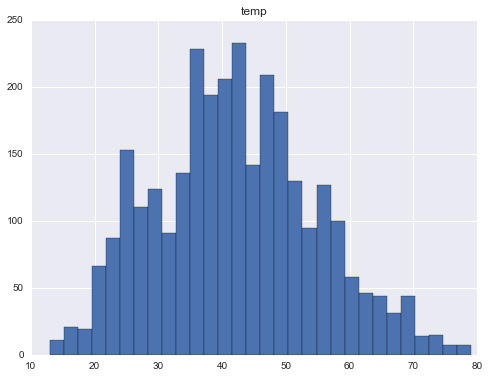

In [271]:
# read the data and set the datetime as the index
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
import pandas as pd
urls = ['../data/KDCA-201601.csv', '../data/KDCA-201602.csv', '../data/KDCA-201603.csv']
frames = [pd.read_csv(url) for url in urls]
weather = pd.concat(frames)
cols = 'WBAN	Date	Time	StationType	SkyCondition	Visibility	WeatherType	DryBulbFarenheit	DryBulbCelsius	WetBulbFarenheit	WetBulbCelsius	DewPointFarenheit	DewPointCelsius	RelativeHumidity	WindSpeed	WindDirection	ValueForWindCharacter	StationPressure	PressureTendency	PressureChange	SeaLevelPressure	RecordType	HourlyPrecip	Altimeter'
cols = cols.split()
weather = weather[cols]
weather.rename(columns={'DryBulbFarenheit':'temp',
                       'RelativeHumidity': 'humidity'}, inplace=True)
# weather['humidity'] = pd.to_numeric(weather.humidity, errors='coerce')

weather['datetime'] = pd.to_datetime(weather.Date.astype(str) + weather.Time.apply('{0:0>4}'.format))
weather['datetime_hour'] = weather.datetime.dt.floor(freq='h')
weather['month'] = weather.datetime.dt.month

bikes = pd.read_csv('../data/2016-Q1-Trips-History-Data.csv')
bikes['start'] = pd.to_datetime(bikes['Start date'], infer_datetime_format=True)
bikes['end'] = pd.to_datetime(bikes['End date'], infer_datetime_format=True)
bikes['datetime_hour'] = bikes.start.dt.floor(freq='h')
weather[['datetime', 'temp']].hist(bins=30)
print(weather.columns)
weather.head()

In [224]:
bikes.merge(weather[['temp', 'datetime_hour', 'datetime']], on='datetime_hour')

,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type,start,end,datetime_hour,temp,datetime
0,301295,3/31/2016 23:59,4/1/2016 0:04,31280,11th & S St NW,31506,1st & Rhode Island Ave NW,W00022,Registered,2016-03-31 23:59:00,2016-04-01 00:04:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
1,557887,3/31/2016 23:59,4/1/2016 0:08,31275,New Hampshire Ave & 24th St NW,31114,18th St & Wyoming Ave NW,W01294,Registered,2016-03-31 23:59:00,2016-04-01 00:08:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
2,555944,3/31/2016 23:59,4/1/2016 0:08,31101,14th & V St NW,31221,18th & M St NW,W01416,Registered,2016-03-31 23:59:00,2016-04-01 00:08:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
3,766916,3/31/2016 23:57,4/1/2016 0:09,31226,34th St & Wisconsin Ave NW,31214,17th & Corcoran St NW,W01090,Registered,2016-03-31 23:57:00,2016-04-01 00:09:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
4,139656,3/31/2016 23:57,3/31/2016 23:59,31011,23rd & Crystal Dr,31009,27th & Crystal Dr,W21934,Registered,2016-03-31 23:57:00,2016-03-31 23:59:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
5,967713,3/31/2016 23:57,4/1/2016 0:13,31266,11th & M St NW,31600,5th & K St NW,W20562,Casual,2016-03-31 23:57:00,2016-04-01 00:13:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
6,534836,3/31/2016 23:57,4/1/2016 0:06,31222,New York Ave & 15th St NW,31278,18th & R St NW,W20222,Registered,2016-03-31 23:57:00,2016-04-01 00:06:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
7,243864,3/31/2016 23:56,4/1/2016 0:00,31228,8th & H St NW,31600,5th & K St NW,W20291,Registered,2016-03-31 23:56:00,2016-04-01 00:00:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
8,372524,3/31/2016 23:55,4/1/2016 0:01,31113,Columbia Rd & Belmont St NW,31234,20th & O St NW / Dupont South,W20590,Registered,2016-03-31 23:55:00,2016-04-01 00:01:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00
9,215194,3/31/2016 23:55,3/31/2016 23:59,31263,10th & K St NW,31265,5th St & Massachusetts Ave NW,W21876,Registered,2016-03-31 23:55:00,2016-03-31 23:59:00,2016-03-31 23:00:00,67,2016-03-31 23:52:00


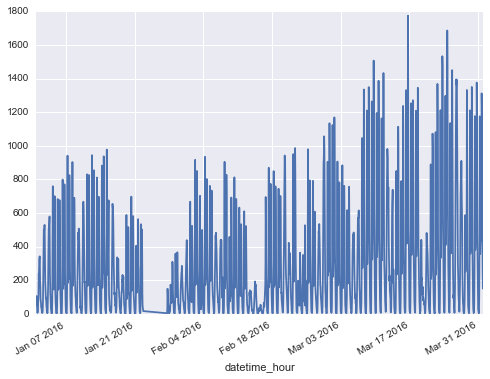

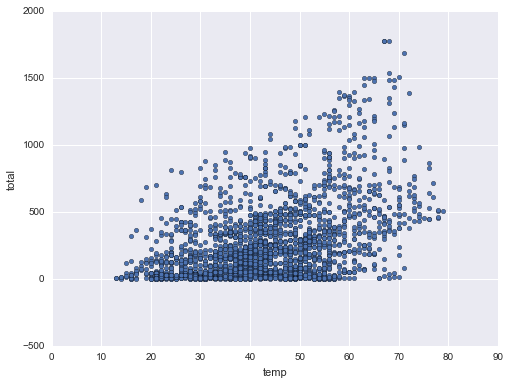

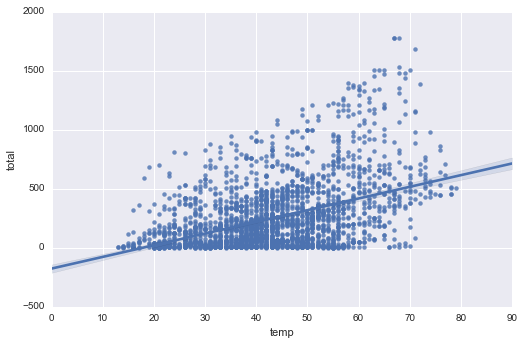

In [277]:
hours = bikes.groupby('datetime_hour').agg('count')
hours['datetime_hour'] = hours.index
hours.head()
hours['total'] = hours.start
hours = hours[['total', 'datetime_hour']]
hours.total.plot()
hours_weather = hours.merge(weather, on='datetime_hour')
hours_weather.plot(kind='scatter', x='temp', y='total')
sns.lmplot(x='temp', y='total', data=hours_weather, aspect=1.5, scatter_kws={'alpha':0.8})

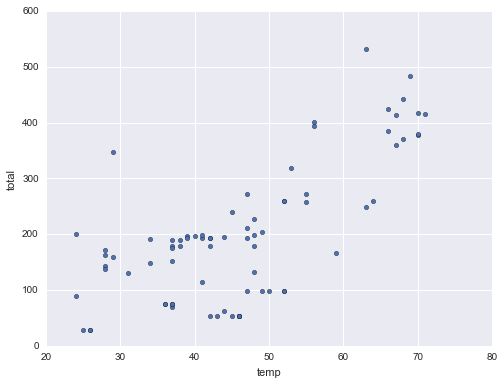

In [226]:
weekday = hours_weather[(hours_weather.datetime.dt.hour==11) & (hours_weather.datetime.dt.dayofweek<5) ]
weekday.plot(kind='scatter', x='temp', y='total')

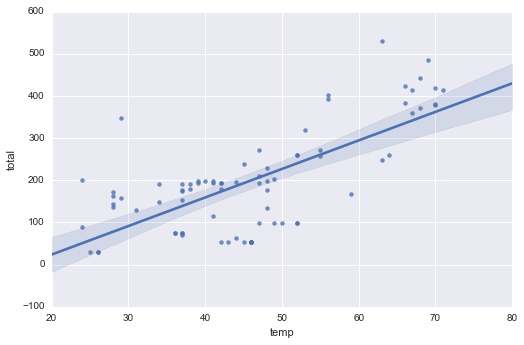

In [227]:
# import seaborn as sns

sns.lmplot(x='temp', y='total', data=weekday, aspect=1.5, scatter_kws={'alpha':0.8})

**Questions:**

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?

## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](../data/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

## Building a linear regression model

In [272]:
# create X and y
feature_cols = ['temp']
X = hours_weather[feature_cols]
y = hours_weather.total

In [273]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [274]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

-176.632263746
[ 9.88748864]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree F is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

## Using the model for prediction

How many bike rentals would we predict if the temperature was 77 degrees F?

In [275]:
# manually calculate the prediction
linreg.intercept_ + linreg.coef_ * 77

array([ 584.70436123])

In [276]:
# use the predict method
linreg.predict(77)

array([ 584.70436123])

## Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [281]:
# create a new column for Fahrenheit temperature
hours_weather['temp_C'] = (hours_weather.temp - 32) * 5/9
hours_weather.head()

,total,datetime_hour,WBAN,Date,Time,StationType,SkyCondition,Visibility,WeatherType,temp,...,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter,datetime,month,temp_C
0,56,2016-01-01 00:00:00,13743,20160101,52,11,BKN046 OVC250,10.0,,44,...,30.09,,,30.15,AA,,30.16,2016-01-01 00:52:00,1,6.666667
1,105,2016-01-01 01:00:00,13743,20160101,152,11,FEW045 BKN230,10.0,,42,...,30.08,,,30.14,AA,,30.15,2016-01-01 01:52:00,1,5.555556
2,74,2016-01-01 02:00:00,13743,20160101,252,11,FEW045 BKN220,10.0,,42,...,30.09,,,30.15,AA,,30.16,2016-01-01 02:52:00,1,5.555556
3,32,2016-01-01 03:00:00,13743,20160101,352,11,BKN220,10.0,,42,...,30.07,,,30.14,AA,,30.14,2016-01-01 03:52:00,1,5.555556
4,13,2016-01-01 04:00:00,13743,20160101,452,11,BKN180 OVC230,10.0,,42,...,30.07,,,30.14,AA,,30.14,2016-01-01 04:52:00,1,5.555556


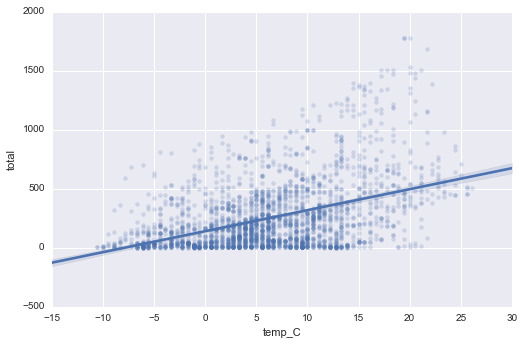

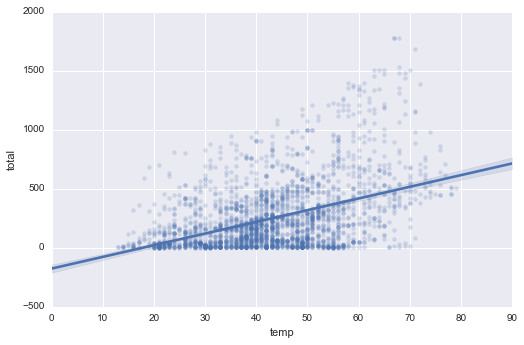

In [282]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_C', y='total', data=hours_weather, aspect=1.5, scatter_kws={'alpha':0.2})
sns.lmplot(x='temp', y='total', data=hours_weather, aspect=1.5, scatter_kws={'alpha':0.2})

In [283]:
# create X and y
feature_cols = ['temp_C']
X = hours_weather[feature_cols]
y = hours_weather.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_, linreg.coef_)

139.767372607 [ 17.79747954]


In [236]:
# convert 77 degrees Fahrenheit to Celsius
(77 - 32)* 5/9

25.0

In [284]:
# predict rentals for 25 degrees Celsius
linreg.predict([[25], [30]])

array([ 584.70436123,  673.69175895])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [239]:
# remove the temp_F column
# bikes.drop('temp_C', axis=1, inplace=True)

## Visualizing the data (part 2)

In [293]:
# explore more features
feature_cols = ['temp', 'month', 'humidity']

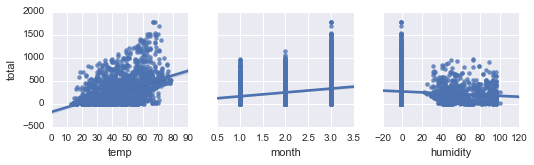

In [294]:
# multiple scatter plots in Seaborn
# print(hours_weather.humidity != 'M')
hours_weather.humidity = hours_weather.humidity.apply(lambda x: -1 if isinstance(x, str) else x)
# hours_weather.loc[hours_weather.humidity.dtype != int].humidity = 100
sns.pairplot(hours_weather, x_vars=feature_cols, y_vars='total', kind='reg')

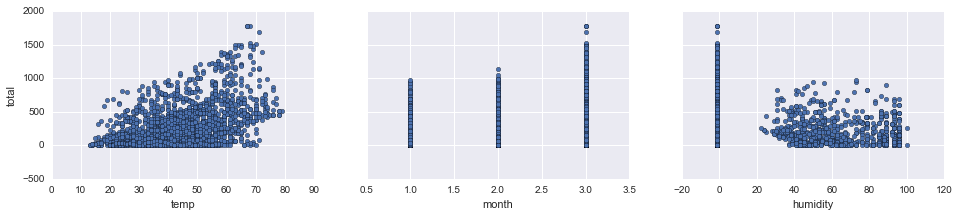

In [242]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    hours_weather.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are you seeing anything that you did not expect?

In [244]:
# cross-tabulation of season and month
pd.crosstab(hours_weather.month, hours_weather.datetime.dt.dayofweek)

datetime,0,1,2,3,4,5,6
month,,,,,,,
1,72,77,98,103,170,151,129
2,203,182,183,115,102,114,125
3,129,139,124,134,123,115,134


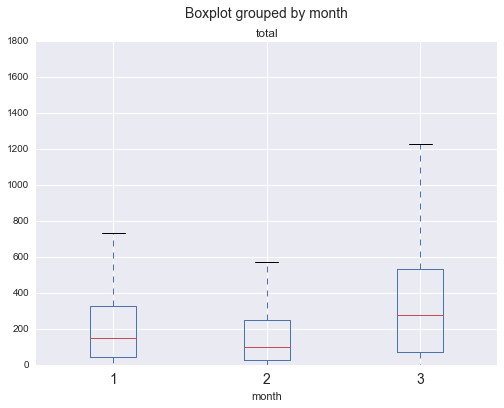

In [245]:
# box plot of rentals, grouped by season
hours_weather.boxplot(column='total', by='month')

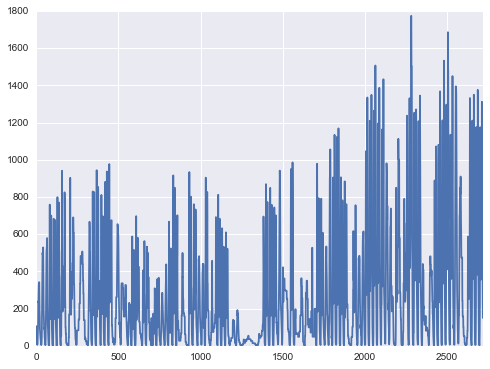

In [246]:
# line plot of rentals
hours_weather.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [247]:
# correlation matrix (ranges from 1 to -1)
hours_weather.corr()

,total,WBAN,Date,Time,StationType,Visibility,temp,DryBulbCelsius,DewPointFarenheit,DewPointCelsius,humidity,Altimeter,month,temp_C
total,1.000000,NaN,0.240069,0.283064,NaN,0.224845,0.437242,0.437254,0.156470,0.156632,-0.109927,-0.038122,0.236981,0.437242
WBAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,0.240069,NaN,1.000000,-0.004699,NaN,0.168070,0.506872,0.506715,0.371529,0.371576,-0.791303,-0.037263,0.994602,0.506872
Time,0.283064,NaN,-0.004699,1.000000,NaN,0.026204,0.120424,0.120322,0.008574,0.008571,-0.025222,-0.032535,-0.007578,0.120424
StationType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Visibility,0.224845,NaN,0.168070,0.026204,NaN,1.000000,0.119073,0.118922,-0.257975,-0.257868,-0.187697,0.075111,0.167172,0.119073
temp,0.437242,NaN,0.506872,0.120424,NaN,0.119073,1.000000,0.999982,0.789360,0.789495,-0.269786,-0.465325,0.499250,1.000000
DryBulbCelsius,0.437254,NaN,0.506715,0.120322,NaN,0.118922,0.999982,1.000000,0.789386,0.789520,-0.269803,-0.465342,0.499113,0.999982
DewPointFarenheit,0.156470,NaN,0.371529,0.008574,NaN,-0.257975,0.789360,0.789386,1.000000,0.999987,-0.121292,-0.533671,0.370406,0.789360
DewPointCelsius,0.156632,NaN,0.371576,0.008571,NaN,-0.257868,0.789495,0.789520,0.999987,1.000000,-0.121358,-0.533625,0.370438,0.789495


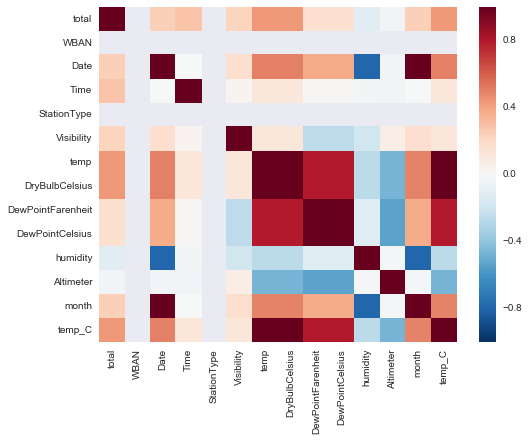

In [248]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(hours_weather.corr())

What relationships do you notice?

## Adding more features to the model

In [251]:
# create a list of features
feature_cols = ['temp', 'month', 'humidity']

In [252]:
# create X and y
X = hours_weather[feature_cols]
y = hours_weather.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_, linreg.coef_)

-226.700163985 [  9.33945424  30.62665914   0.60483008]


In [253]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('temp', 9.3394542400038798),
 ('month', 30.626659142039028),
 ('humidity', 0.60483007751778484)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 9.3 bikes**.
- Holding all other features fixed, a 1 unit increase in **month** is associated with a **rental increase of 30.6 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of .60 bikes**.

Does anything look incorrect?

## Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

## Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [285]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [286]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.73861278753


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [289]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))
rmse = np.sqrt(metrics.mean_squared_error(true, pred))
rmse/pred

MAE: 2.0
MSE: 16.0
RMSE: 4.0


array([ 0.4       ,  0.57142857,  0.8       ,  0.30769231])

## Comparing models with train/test split and RMSE

In [295]:
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import numpy as np

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols, data):
    X = data[feature_cols]
    y = data.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [298]:
# compare different sets of features
print(train_test_rmse(['temp', 'month', 'humidity'], hours_weather))
print(train_test_rmse(['temp', 'month'], hours_weather))
print(train_test_rmse(['temp', 'humidity'], hours_weather))
print(train_test_rmse(['temp'], hours_weather))
print(train_test_rmse(['temp'], weekday))

246.451640105
246.783327002
246.572708806
246.56944026
81.4084240105


## Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

In [301]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(weekday[['temp']], weekday.total, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([ 260.05,  260.05,  260.05,  260.05,  260.05,  260.05,  260.05,
        260.05,  260.05,  260.05,  260.05,  260.05,  260.05,  260.05,
        260.05,  260.05,  260.05,  260.05,  260.05,  260.05])

In [302]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

111.40173921443058

## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [303]:
# create dummy variables
season_dummies = pd.get_dummies(hours_weather.month, prefix='month')

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,month_1,month_2,month_3
1443,0.0,1.0,0.0
1152,0.0,1.0,0.0
1348,0.0,1.0,0.0
1334,0.0,1.0,0.0
2700,0.0,0.0,1.0


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [304]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
hw_dum = pd.concat([hours_weather, season_dummies], axis=1)

# print 5 random rows
hw_dum.sample(n=5, random_state=1)

,total,datetime_hour,WBAN,Date,Time,StationType,SkyCondition,Visibility,WeatherType,temp,...,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter,datetime,month,temp_C,month_1,month_2,month_3
1443,2,2016-02-19 02:00:00,13743,20160219,252,11,CLR,10.00,,30,...,30.57,AA,,30.57,2016-02-19 02:52:00,2,-1.111111,0.0,1.0,0.0
1152,40,2016-02-12 05:00:00,13743,20160212,552,11,BKN180,10.00,,20,...,30.32,AA,,30.32,2016-02-12 05:52:00,2,-6.666667,0.0,1.0,0.0
1348,3,2016-02-16 04:00:00,13743,20160216,405,11,VV002,0.12,FZFG,31,...,M,SP,,29.83,2016-02-16 04:05:00,2,-0.555556,0.0,1.0,0.0
1334,8,2016-02-15 23:00:00,13743,20160215,2328,11,OVC006,7.00,-FZDZ,30,...,M,SP,,30.06,2016-02-15 23:28:00,2,-1.111111,0.0,1.0,0.0
2700,2,2016-03-31 03:00:00,13743,20160331,352,11,SCT250,10.00,,55,...,30.03,AA,,30.04,2016-03-31 03:52:00,3,12.777778,0.0,0.0,1.0


In [312]:
# include dummy variables for season in the model
feature_cols = ['temp','month_1', 'month_2', 'month_3', 'humidity']
X = hw_dum[feature_cols]
y = hw_dum.total
linreg = LinearRegression()
linreg.fit(X, y)
list(zip(feature_cols, linreg.coef_))

[('temp', 9.4424422534193386),
 ('month_1', 136.77031870520233),
 ('month_2', -109.63094296109043),
 ('month_3', -27.139375744111014),
 ('humidity', -2.7144997426796094)]

In [309]:
# compare original season variable with dummy variables
print(train_test_rmse(['temp', 'month', 'humidity'], hw_dum))
print(train_test_rmse(['temp', 'month_2', 'month', 'humidity'], hw_dum))
print(train_test_rmse(['temp', 'month_2', 'month_1', 'humidity'], hw_dum))

246.451640105
240.628565747
240.628565747


## Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

In [267]:
# hour as a numeric feature
hw_dum['hour'] = hw_dum.datetime.dt.hour

In [268]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(hw_dum.hour, prefix='hour')
# hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
hw_dum = pd.concat([hw_dum, hour_dummies], axis=1)

In [269]:
# daytime as a categorical feature
hw_dum['daytime'] = ((hw_dum.hour > 6) & (hw_dum.hour < 21)).astype(int)

In [270]:
print(train_test_rmse(['hour'], hw_dum),
    train_test_rmse(hw_dum.columns[hw_dum.columns.str.startswith('hour_')], hw_dum)
    ,train_test_rmse(['daytime'], hw_dum))

261.836828231 212.27200657 229.412966447


## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions